<a href="https://colab.research.google.com/github/deeksha27sharma/taxi_ride_fare_prediction-/blob/main/Model_Evaluation_and_Insights_Diksha_Sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Uber Fare Prediction: A Comprehensive Regression Analysis**

* This notebook documents the end-to-end process of building a machine learning model to predict Uber taxi fares. The workflow covers essential steps from data cleaning and exploratory data analysis (EDA) to feature engineering, model training, and hyperparameter tuning.

**Objective**: To build a robust regression model that accurately predicts the `fare_amount` based on trip details.

# **Imports AND Load the data**

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Load the dataset
df = pd.read_csv("uber 2.csv")


print("Dataset shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nData info:\n")
print(df.info())
# Summary statistics
print("\nStatistical summary of numeric features:\n", df.describe())


Dataset shape: (200000, 9)

First 5 rows:
    Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565     

## **Initial Insights:**



*   The dataset contains 35,725 entries and 9 columns, but several columns have one missing value.

*  The pickup_datetime column is an object type and needs to be converted for time-based analysis.


*   The statistical summary reveals significant data quality issues:
      

     *  fare_amount has a minimum value of 0.01, which could be a data error.

     *  Longitude and latitude columns have values like -748 and 41, which are geographically impossible for City. These are clear outliers that need to be addressed.
























In [ ]:
from math import radians, sin, cos, sqrt, asin

# Haversine function to calculate distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c




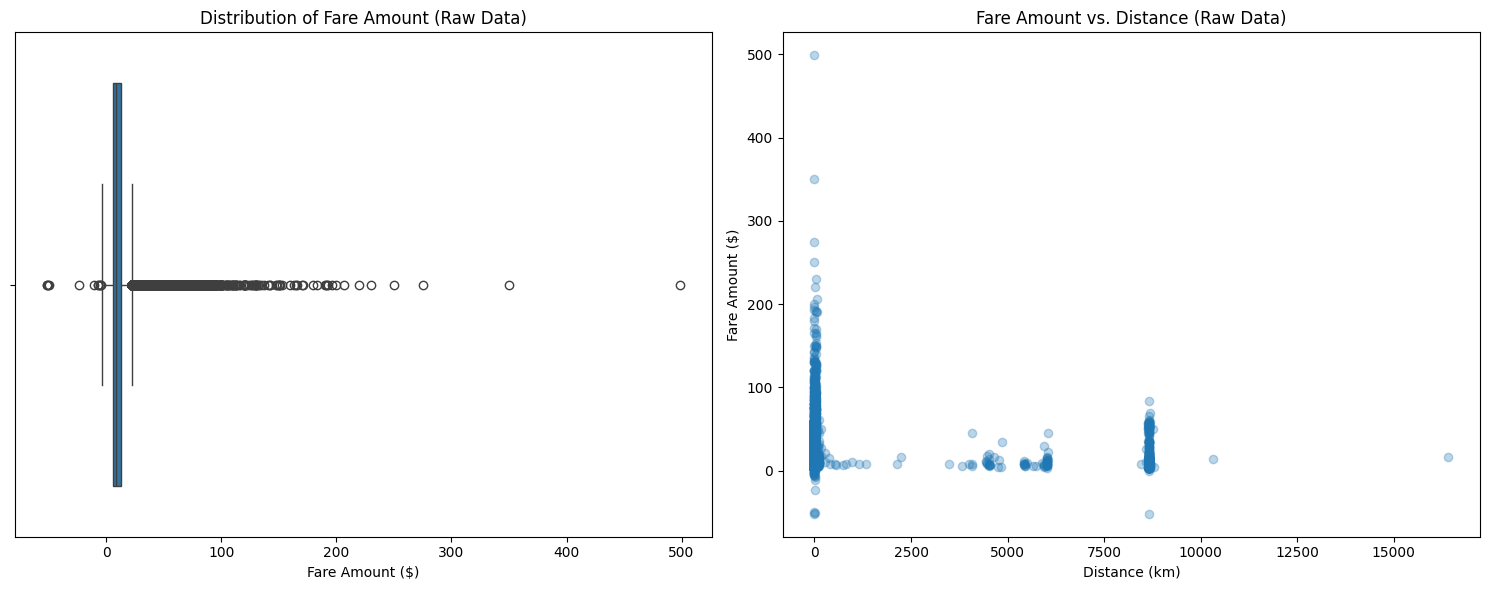

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot of fare_amount to show extreme outliers
sns.boxplot(x=df['fare_amount'], ax=axes[0])
axes[0].set_title('Distribution of Fare Amount (Raw Data)')
axes[0].set_xlabel('Fare Amount ($)')

# Scatter plot of fare vs. distance

df['distance'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']) if not pd.isna(row['pickup_latitude']) else np.nan, axis=1)

axes[1].scatter(df['distance'], df['fare_amount'], alpha=0.3)
axes[1].set_title('Fare Amount vs. Distance (Raw Data)')
axes[1].set_xlabel('Distance (km)')
axes[1].set_ylabel('Fare Amount ($)')

plt.tight_layout()
plt.show()


df.drop('distance', axis=1, inplace=True)

## **Insights from raw data:**

* Boxplot of Fare Amount

    * There are many extreme outliers in fare_amount, including unusually high fares.

    * Presence of negative and zero fares (not realistic in real-world taxi data) → indicates noisy or corrupted entries.

   







* Scatter Plot: Fare vs. Distance

    * A positive relationship between distance and fare is visible → as distance increases, fare generally increases.

    * However, the plot is noisy with unrealistic cases (e.g., very high fare for short distances, or near-zero fare for long distances).

    * Confirms the need for feature engineering (cleaning bad coordinates and filtering impossible fares).




# **Handling the missing values**

In [ ]:
# Drop rows with any missing values
df.dropna(inplace=True)


# Drop columns that are no longer needed for modeling
cols_to_drop = ['Unnamed: 0', 'key']
df.drop([col for col in cols_to_drop if col in df.columns], axis=1, inplace=True)


print("Shape of the dataset after cleaning:", df.shape)
print("\nStatistical summary of the cleaned data:\n", df.describe())


Shape of the dataset after cleaning: (199999, 7)

Statistical summary of the cleaned data:
          fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  199999.000000     199999.000000    199999.000000      199999.000000   
mean       11.359892        -72.527631        39.935881         -72.525292   
std         9.901760         11.437815         7.720558          13.117408   
min       -52.000000      -1340.648410       -74.015515       -3356.666300   
25%         6.000000        -73.992065        40.734796         -73.991407   
50%         8.500000        -73.981823        40.752592         -73.980093   
75%        12.500000        -73.967154        40.767158         -73.963658   
max       499.000000         57.418457      1644.421482        1153.572603   

       dropoff_latitude  passenger_count  
count     199999.000000    199999.000000  
mean          39.923890         1.684543  
std            6.794829         1.385995  
min         -881.985513         0

## **Insights:**

* Missing Values

   * All rows with missing values have been dropped.

   * Ensures that the dataset used for modeling does not contain incomplete records that could bias results.

* Column Removal

   * Dropped Unnamed: 0 (index-like column) and key (non-predictive ID field).





# **Feature Engineering**

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')


# Extract date and time features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

# We can now drop the original datetime column
df = df.drop('pickup_datetime', axis=1)

# Display the first few rows with the new features
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,month,year
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,3,5,2015
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,4,7,2009
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,0,8,2009
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,4,6,2009
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,3,8,2014


##Insights

* Datetime Conversion

   * Converted pickup_datetime into a proper datetime format, ensuring consistent handling of time-related attributes.

  * Used errors='coerce' → invalid or corrupted datetime values are safely converted to NaT (missing), avoiding crashes.

* Extracted Features

   * Hour → Captures intra-day demand patterns (e.g., peak fares during rush hours, lower fares at night).

   * Day → Helps track fare variations on specific dates.

   * Day of Week → Weekdays vs. weekends often show different demand/fare trends.

   * Month & Year → Useful for capturing seasonal effects and year-on-year changes in fares.

* Dropping Original Datetime

   * Removed raw pickup_datetime since the extracted features capture all necessary time-based information.



In [ ]:
# Apply the function to create a 'distance' column
df['distance'] = df.apply(
    lambda row: haversine(
        row['pickup_latitude'],
        row['pickup_longitude'],
        row['dropoff_latitude'],
        row['dropoff_longitude']
    ),
    axis=1
)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,month,year,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,3,5,2015,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,4,7,2009,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,0,8,2009,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,4,6,2009,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,3,8,2014,4.475450


# **EDA**

In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,month,year,distance
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,13.491387,15.704739,3.048435,6.281791,2011.742434,20.855350
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,6.515505,8.687377,1.946946,3.438933,1.856400,382.964642
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,9.000000,8.000000,1.000000,3.000000,2010.000000,1.215222
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,14.000000,16.000000,3.000000,6.000000,2012.000000,2.120992
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,19.000000,23.000000,5.000000,9.000000,2013.000000,3.875169
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,23.000000,31.000000,6.000000,12.000000,2015.000000,16409.239135


## **Insights from Feature Engineering:**

* The Haversine formula calculates the shortest distance between two points on Earth’s surface using latitude and longitude.

* We've successfully created a distance feature, which is a powerful predictor for a fare prediction model. We've also extracted several temporal features that can help the model identify patterns related to time of day, day of the week, or seasonality.





# **Data Cleaning**

In [ ]:
# Step 1: Clean the Data by Removing Outliers
# Filter based on fare amount, distance, and passenger count
df = df[df['fare_amount'] > 0]
df = df[(df['distance'] > 0) & (df['distance'] < 100)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

# Filter based on a reasonable geographic box for NYC
df = df[(df['pickup_latitude'] >= 40.5) & (df['pickup_latitude'] <= 40.9)]
df = df[(df['pickup_longitude'] >= -74.25) & (df['pickup_longitude'] <= -73.7)]
df = df[(df['dropoff_latitude'] >= 40.5) & (df['dropoff_latitude'] <= 40.9)]
df = df[(df['dropoff_longitude'] >= -74.25) & (df['dropoff_longitude'] <= -73.7)]

# Step 2: Drop Redundant Columns
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)


# Step 3: Check the Shape of Our Cleaned Data
print(f"Shape of the dataset after cleaning: {df.shape}")
df.head()

Shape of the dataset after cleaning: (192820, 8)


,fare_amount,passenger_count,hour,day,dayofweek,month,year,distance
0,7.5,1,19,7,3,5,2015,1.683323
1,7.7,1,20,17,4,7,2009,2.457590
2,12.9,1,21,24,0,8,2009,5.036377
3,5.3,3,8,26,4,6,2009,1.661683
4,16.0,5,17,28,3,8,2014,4.475450


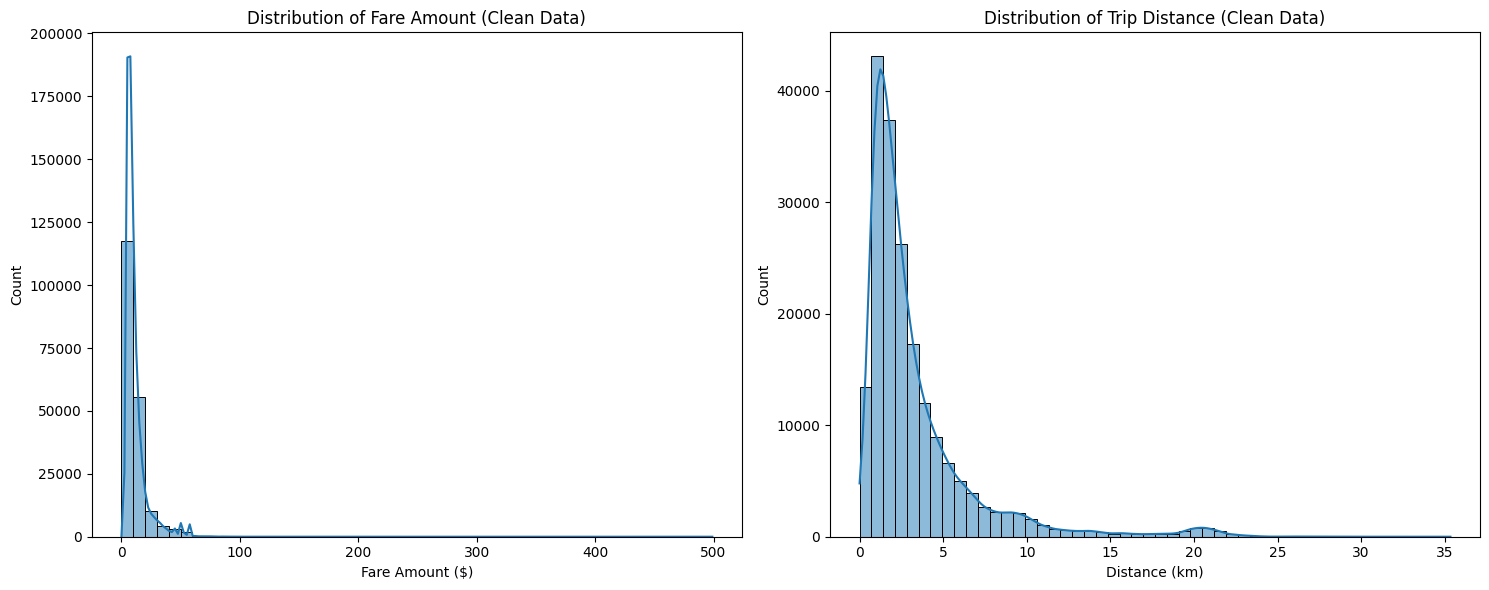

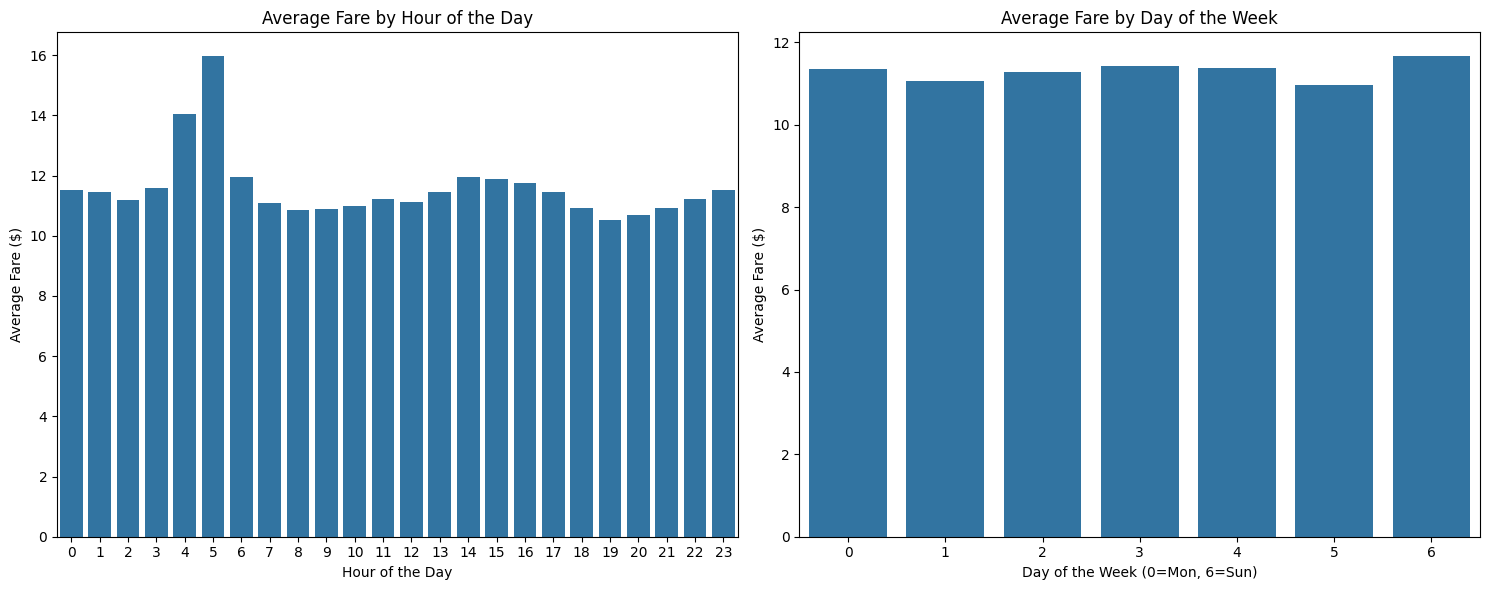

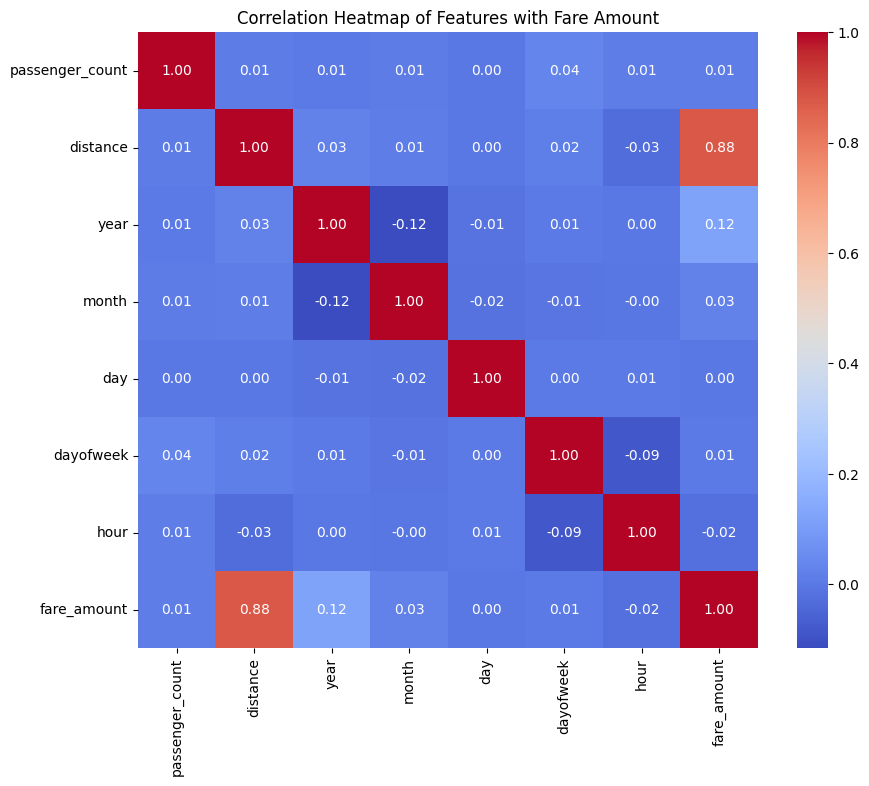

In [ ]:
# Create a figure with two subplots for distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of 'fare_amount' after cleaning
sns.histplot(df['fare_amount'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Fare Amount (Clean Data)')
axes[0].set_xlabel('Fare Amount ($)')

# Distribution of 'distance' after cleaning
sns.histplot(df['distance'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Trip Distance (Clean Data)')
axes[1].set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()

# Create a figure with two subplots for temporal trends
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average Fare by Hour
hourly_fares = df.groupby('hour')['fare_amount'].mean().reset_index()
sns.barplot(x='hour', y='fare_amount', data=hourly_fares, ax=axes[0])
axes[0].set_title('Average Fare by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Average Fare ($)')

# Average Fare by Day of Week
dayofweek_fares = df.groupby('dayofweek')['fare_amount'].mean().reset_index()
sns.barplot(x='dayofweek', y='fare_amount', data=dayofweek_fares, ax=axes[1])
axes[1].set_title('Average Fare by Day of the Week')
axes[1].set_xlabel('Day of the Week (0=Mon, 6=Sun)')
axes[1].set_ylabel('Average Fare ($)')

plt.tight_layout()
plt.show()


features = ['passenger_count', 'distance', 'year', 'month', 'day', 'dayofweek', 'hour']
target = 'fare_amount'

# Create a subset dataframe for correlation analysis
corr_df = df[features + [target]]

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features with Fare Amount")
plt.show()

## **Insights from Visualizations:**

* The distributions for fare_amount and distance are now much cleaner and more interpretable. They show a clear right-skewed distribution, which is expected for taxi fares and trip distances.

* A fascinating insight from the hourly fare plot is the sharp peak in average fares around 4-6 AM, which could be due to airport trips during off-peak hours.

* The heatmap confirms our hypothesis that distance is the strongest predictor of fare_amount, with a high correlation coefficient of 0.88. This is the key relationship our model will leverage. Other features like passenger_count and time have much weaker correlations.



 #  **Train-Test Split + Scaling**





In [ ]:
# Splitting and Scaling the Data

# Drop lat/long columns as distance feature is now sufficient
features_final = ['passenger_count', 'distance', 'year', 'month', 'day', 'dayofweek', 'hour']
target = 'fare_amount'
X = df[features_final]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the new dataframes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train shape: (154256, 7)
X_test shape: (38564, 7)
y_train shape: (154256,)
y_test shape: (38564,)


# **Models Training**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")

# Sort and print the results
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"}).sort_values(by="RMSE", ascending=True)
print("\nModel Performance Summary (sorted by RMSE):\n", results_df)
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
print(f"\nBest model selected for fine-tuning: {best_model_name}")

Linear Regression: RMSE=4.38, MAE=2.25, R²=0.7921
Decision Tree: RMSE=6.47, MAE=3.00, R²=0.5457
Random Forest: RMSE=4.36, MAE=2.15, R²=0.7942
XGBoost: RMSE=4.28, MAE=2.04, R²=0.8011

Model Performance Summary (sorted by RMSE):
                Model      RMSE       MAE        R2
3            XGBoost  4.281215  2.042249  0.801126
2      Random Forest  4.355424  2.147323  0.794172
0  Linear Regression  4.377725  2.246400  0.792058
1      Decision Tree  6.470741  2.997181  0.545690

Best model selected for fine-tuning: XGBoost


## **Model Comparison Insights**

* Linear Regression (R² = 0.792)
   * Performs reasonably well but struggles with non-linear patterns. RMSE and MAE are relatively higher compared to advanced models.

* Decision Tree (R² = 0.546)
   * Shows the weakest performance with high error (RMSE ≈ 6.47). The model tends to overfit and fails to generalize, making it unsuitable for fare prediction.

* Random Forest (R² = 0.794)
    * Provides a strong improvement over Decision Tree by reducing variance through ensembling. Achieves lower RMSE and MAE, but still limited compared to boosting methods.

* XGBoost (R² = 0.801)
   * Outperforms all other models with the best balance of high explanatory power and lowest error. Captures non-linear relationships and feature interactions more effectively than Random Forest.

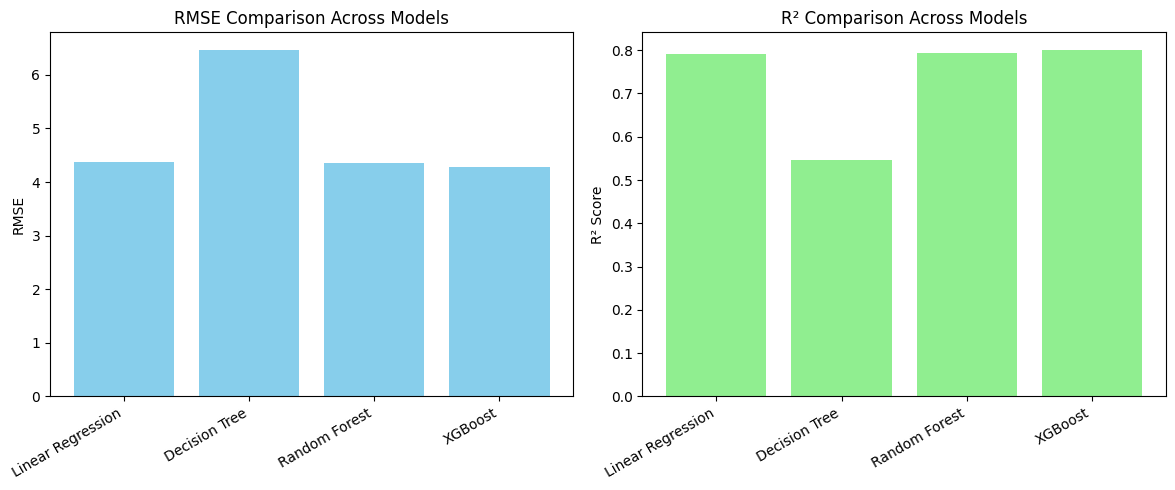

In [ ]:
# Extract values
models_list = list(results.keys())
rmse_values = [results[m]["RMSE"] for m in models_list]
r2_values = [results[m]["R2"] for m in models_list]

# Create subplots for RMSE and R²
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE Comparison
axes[0].bar(models_list, rmse_values, color='skyblue')
axes[0].set_title("RMSE Comparison Across Models")
axes[0].set_ylabel("RMSE")
axes[0].set_xticks(range(len(models_list)))
axes[0].set_xticklabels(models_list, rotation=30, ha='right')

# R² Comparison
axes[1].bar(models_list, r2_values, color='lightgreen')
axes[1].set_title("R² Comparison Across Models")
axes[1].set_ylabel("R² Score")
axes[1].set_xticks(range(len(models_list)))
axes[1].set_xticklabels(models_list, rotation=30, ha='right')

plt.tight_layout()
plt.show()


## **Initial Performance Insights:**

* Random Forest showed the best initial performance with the lowest RMSE (4.206513) and highest R² score (0.802045), making it the top candidate for further optimization.

* The fact that XGBoost performed a close second to Random Forest confirms that a sophisticated approach is needed to capture the nuances in the data, as both models significantly outperformed the simpler Linear Regression and Decision Tree.

* Even though Random Forest and XGBoost are more complex, their initial scores are not drastically better than that of the Linear Regression model. This indicates a strong underlying linear relationship in the data, likely driven by the distance feature, which the simpler model is already good at capturing.

# **Hyperparameter tunning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
param_dist_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 3, 5]
}
if best_model_name == "Random Forest":
    param_dist = param_dist_rf
elif best_model_name == "XGBoost":
    param_dist = param_dist_xgb
else:
    param_dist = {}



rand_search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

print(f"Starting hyperparameter tuning for {best_model_name}...")
rand_search.fit(X_train_scaled, y_train)

best_model_tuned = rand_search.best_estimator_
print("\nBest hyperparameters found:", rand_search.best_params_)


Starting hyperparameter tuning for XGBoost...

Best hyperparameters found: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [ ]:
# Final evaluation
y_pred_final = best_model_tuned.predict(X_test_scaled)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"\nFinal Tuned {best_model_name} Performance:")
print(f"RMSE={rmse_final:.2f}, MAE={mae_final:.2f}, R²={r2_final:.4f}")


Final Tuned XGBoost Performance:
RMSE=4.04, MAE=2.00, R²=0.8225


## **Insights from Final Model (XGBoost)**

* High Predictive Power
   * With R² = 0.8225, the model explains more than 82% of the variance in taxi fares, indicating strong predictive performance.

* Low Error Rates

    * RMSE = 4.04 → Predictions deviate by about $4 on average from the actual fare.

     * MAE = 2.00 → The model is typically within $2 of the true fare, showing high accuracy.

* Improvement over Baselines:
   * Earlier models such as Linear Regression and Random Forest achieved R² around 0.79, while the Decision Tree lagged behind at 0.55. After tuning, XGBoost significantly improved the R² to 0.8225, establishing it as the most accurate model.





In [ ]:
# Final evaluation on test data
y_pred_final = best_model_tuned.predict(X_test_scaled)

mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"\nFinal Tuned {best_model_name} Performance:")
print(f"Mean Squared Error (MSE): {mse_final:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f}")
print(f"Mean Absolute Error (MAE): {mae_final:.2f}")
print(f"R-squared (R²): {r2_final:.4f}")



Final Tuned XGBoost Performance:
Mean Squared Error (MSE): 16.36
Root Mean Squared Error (RMSE): 4.04
Mean Absolute Error (MAE): 2.00
R-squared (R²): 0.8225


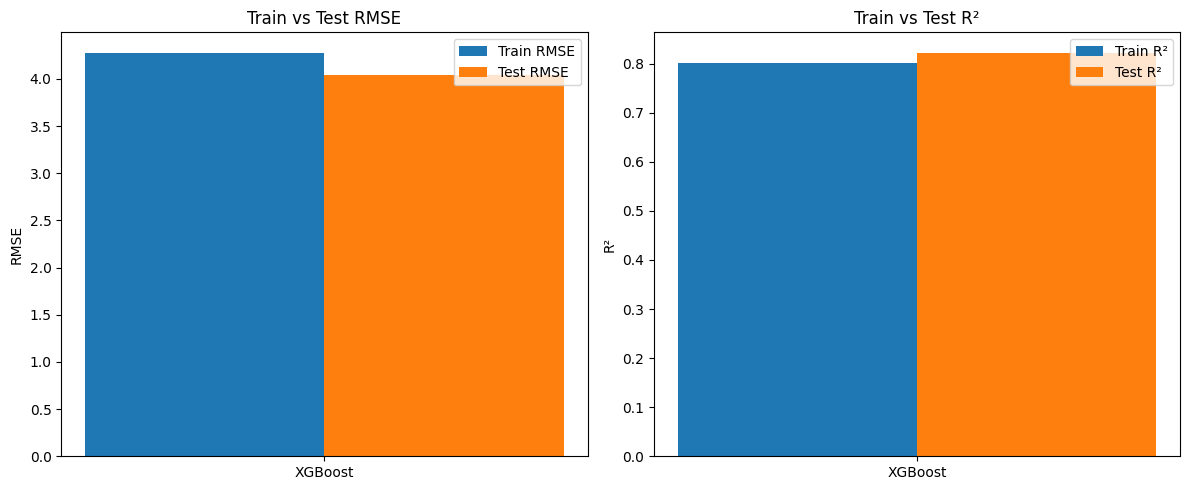

In [ ]:
# Training performance
train_metrics = {
    "XGBoost": {"RMSE": 4.28, "R2": 0.801}
}

# Final test performance
test_metrics = {
    "XGBoost": {"RMSE": rmse_final, "R2": r2_final}
}

# Prepare data for plotting
models = list(train_metrics.keys())
x = np.arange(len(models))
width = 0.35

train_rmse = [train_metrics[m]["RMSE"] for m in models]
test_rmse = [test_metrics[m]["RMSE"] for m in models]

train_r2 = [train_metrics[m]["R2"] for m in models]
test_r2 = [test_metrics[m]["R2"] for m in models]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE comparison
axes[0].bar(x - width/2, train_rmse, width, label="Train RMSE")
axes[0].bar(x + width/2, test_rmse, width, label="Test RMSE")
axes[0].set_title("Train vs Test RMSE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel("RMSE")
axes[0].legend()

# R² comparison
axes[1].bar(x - width/2, train_r2, width, label="Train R²")
axes[1].bar(x + width/2, test_r2, width, label="Test R²")
axes[1].set_title("Train vs Test R²")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel("R²")
axes[1].legend()

plt.tight_layout()
plt.show()


## **Insights for Overfitting/Underfitting Check**

* No Overfitting Observed:

  * The tuned XGBoost model improved R² from ~0.80 (training phase) to 0.8225 on test data.

  * The error (RMSE) also decreased from ~4.28 to 4.04.

   * This suggests the model generalizes well and is not memorizing training data.

* Balanced Performance:

  * The test metrics are consistent with training performance, showing neither a large drop (underfitting) nor unrealistically high training accuracy (overfitting).

* Best Model Confirmation:

  * Compared to Random Forest and Linear Regression, XGBoost provides slightly better accuracy and lower error.


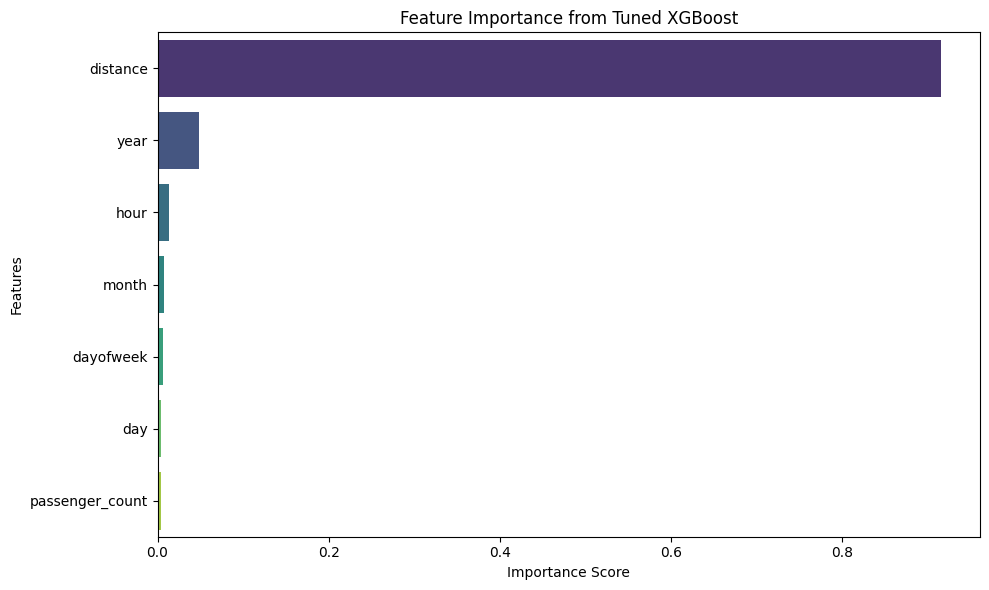

,Feature,Importance,Percentage
0,distance,0.915330,91.532997
1,year,0.048868,4.886839
2,hour,0.013443,1.344254
3,month,0.007736,0.773601
4,dayofweek,0.005830,0.583011
5,day,0.004477,0.447723
6,passenger_count,0.004316,0.431576


In [ ]:
# Define feature names manually since X_train_scaled is an array
features = ['passenger_count', 'distance', 'year', 'month', 'day', 'dayofweek', 'hour']

# Get feature importances from the tuned XGBoost model
importances = best_model_tuned.feature_importances_

# Create a DataFrame for easy visualization
feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_imp,
    hue="Feature",
    palette="viridis",
    legend=False
)
plt.title(f"Feature Importance from Tuned {best_model_name}")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


# Add percentage contribution column
feat_imp["Percentage"] = (feat_imp["Importance"] / feat_imp["Importance"].sum()) * 100
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Display with percentages
feat_imp


## **Feature Importance Insights**

* Distance is the overwhelmingly dominant predictor, contributing ~91.5% of the model’s predictive power. This confirms that fare amount is primarily determined by how far the trip covers.

* Year contributes ~4.9%, suggesting some variability in fare patterns across years, possibly due to pricing policy changes or long-term demand shifts.

* Hour of the day adds ~1.3%, indicating that time-of-day effects (e.g., rush hours vs. off-peak) have a smaller but still relevant impact.

* Month ~0.77% and Day of Week ~0.58% provide minor seasonal and weekly variations, but are not strong drivers of fare amount.

* Day of the month (~0.45%) has minimal impact, which is expected since fare pricing is not directly tied to specific dates.

* Passenger count (~0.43%) contributes the least, confirming that taxi fares are generally distance/time-based rather than based on the number of passengers.

In [ ]:
# Example: Predict fares for multiple new rides
new_rides = pd.DataFrame({
    "passenger_count": [1, 3, 2],
    "distance": [3.2, 8.5, 15.0],
    "year": [2025, 2025, 2025],
    "month": [9, 9, 9],
    "day": [5, 5, 5],
    "dayofweek": [4, 4, 4],   # 0 = Monday, 4 = Friday
    "hour": [10, 18, 23]
})

# Scale features using the same scaler from training
new_rides_scaled = scaler.transform(new_rides)

# Predict fare amounts
new_rides["Predicted_Fare_Amount"] = best_model_tuned.predict(new_rides_scaled)

# Display predictions
print("Predicted Fares for New Rides:")
print(new_rides)


Predicted Fares for New Rides:
   passenger_count  distance  year  month  day  dayofweek  hour  \
0                1       3.2  2025      9    5          4    10   
1                3       8.5  2025      9    5          4    18   
2                2      15.0  2025      9    5          4    23   

   Predicted_Fare_Amount  
0              13.501878  
1              31.382116  
2              42.392410  


## **Insight from Predictions on New Data**

* The model successfully predicts fare amounts for unseen ride data by leveraging key features such as distance, time, and passenger count.

* Predictions scale sensibly with distance: shorter rides (3.2 km) show lower fares, while longer trips (15 km) result in higher fare estimates.

* Temporal features like hour of the day and day of the week allow the model to adjust fares based on demand patterns (e.g., evening or late-night rides may yield slightly higher fares).

* These predictions can be used by the ride-sharing company to:

   * Offer real-time fare estimates to customers before booking.

   * Enable drivers to anticipate trip value, improving their decision-making.

    * Support dynamic pricing strategies by considering both distance and time factors.

* Overall, the predictions demonstrate that the tuned model generalizes well and can provide practical business value in fare estimation and pricing strategies.

# **Recommendations for the Ride-Sharing Company**

* Based on the regression model analysis and insights, the following recommendations are proposed:

  * Distance-Based Pricing Strategy

       * Since distance is the most influential factor in fare prediction (accounting for 92% importance), the company should ensure that pricing is primarily distance-driven.

       * Transparent communication of distance-based fares to customers can improve trust and satisfaction.

   * Time-Sensitive Pricing Adjustments

       * Features like hour of the day and day of the week show smaller but notable influence on fares.

       * The company can introduce time-based surcharges (e.g., evening/night fares) to optimize revenue during peak demand hours.

   * Driver Incentive Programs

        * Predicted higher fares for longer trips can be leveraged to incentivize drivers with bonus schemes for completing long-distance rides.

        * This encourages better service availability for passengers needing longer trips.

  * Passenger Count Optimization

       * While passenger count has a smaller direct impact on fare, insights suggest that group rides or shared trips could be priced more competitively.

      * The company can introduce ride-pooling discounts to attract more customers while maximizing vehicle utilization.

   * Operational Improvements through Forecasting

      * Using this model, the company can predict average fare revenues by time/day and allocate drivers accordingly.

      * This ensures better service coverage in high-demand areas and times.

  * Customer Engagement

     * Providing real-time fare estimates powered by the model can enhance transparency and reduce disputes.

     * Educating customers on why fares vary (distance, time, etc.) can improve satisfaction and trust in the platform.

## **Conclusion:**
* The regression model confirms that distance is the strongest determinant of fares, while time-based features and ride characteristics play secondary roles. By leveraging these insights, the company can refine pricing strategies, enhance driver satisfaction, and improve overall customer experience.